In [1]:
import glob
import os
import re
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import StringIO
import pandas as pd
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

PDF_DIR = '/med/pdbrepo/pdb_pubmed_pdfs/pdfs'
TXT_DIR = '/med/pdbrepo/pdb_pubmed_pdfs/txts'
PUBMED_PDF_CSV = '/med/pdbrepo/pdb_pubmed_pdfs/pmids.csv'
PHRASES_CSV = "/med/pdbrepo/pdb_pubmed_pdfs/pubmed_phrases.csv"
TECHNIQUES_FILE = 'biochemical_techniques_list.txt'

In [2]:
def convert_pdf_to_txt(path, pages=None):
    with StringIO() as output:
        manager = PDFResourceManager()
        
        with TextConverter(manager, output, laparams=LAParams()) as converter:
            interpreter = PDFPageInterpreter(manager, converter)

            with open(path, 'rb') as infile:
                for page in PDFPage.get_pages(infile, set()):
                    interpreter.process_page(page)

        text = output.getvalue()
    
    return text.replace("\n", " ").replace("- ", "")


def create_regex_dict_from_phrases(phrase_list):
    phrase_regex_dict = {}
    
    for phrase in phrase_list:
        phrase_regex_dict[phrase] = re.compile(phrase, re.IGNORECASE)
        
    return phrase_regex_dict


def check_if_text_contains_phrases(pubmed_id, text, phrase_regex_dict):
    hit_dict = {}
    hit_dict["PubMed id"] = pubmed_id
    hit_dict["Total number of phrases found"] = 0
    hit_sum = 0
    
    for phrase in phrase_regex_dict.keys():
        is_hit = re.search(phrase_regex_dict[phrase], text) is not None
        hit_dict[phrase] = [1 if is_hit else 0]
        
        if is_hit:
            hit_sum += 1
        
    hit_dict["Total number of phrases found"] = hit_sum
    hit_df = pd.DataFrame(hit_dict)
    hit_df = hit_df.set_index("PubMed id")
        
    return hit_df


def get_pdf_text(pubmed_id, pdf_path):
    txt_path = os.path.join(TXT_DIR, pubmed_id + ".txt")
    
    if os.path.exists(txt_path):
        with open(txt_path, "r") as text_file:
            pdf_text = text_file.read()
    else:
        pdf_text = convert_pdf_to_txt(pdf_path)
        with open(txt_path, "w") as text_file:
            text_file.write(pdf_text)
            
    return pdf_text

def analyze_pdf(pdf, phrase_regex_dict):
    try:
        pubmed_id = pdf.split('/')[-1][:-4]
        pdf_text = get_pdf_text(pubmed_id, pdf)
        hit_df = check_if_text_contains_phrases(pubmed_id, pdf_text, phrase_regex_dict)
    except:
        hit_df = None
    
    return hit_df


def analyze_pdfs(pdfs, phrases_list, max_count=None, n_jobs=1, parallel=False):
    result_df = pd.DataFrame()
    phrase_regex_dict = create_regex_dict_from_phrases(phrases_list)

    if max_count is not None and max_count != -1:
        pdfs = pdfs[:max_count]
    
    if parallel:
        hit_dfs = Parallel(n_jobs=n_jobs)(delayed(analyze_pdf)(pdf, phrase_regex_dict) for pdf in tqdm(pdfs))
    else:
        hit_dfs = [analyze_pdf(pdf, phrase_regex_dict) for pdf in tqdm(pdfs)]

    return pd.concat(hit_dfs)

def read_pmid_csv(csv_filename):
    df = pd.read_csv(csv_filename, keep_default_na=False, na_values=["", '""'])
    return df

In [3]:
pubmed_pdfs = glob.glob(f'{PDF_DIR}/*.pdf') 
with open(TECHNIQUES_FILE) as file:
    techniques_list = file.read().rstrip().lower().split('\n')

In [4]:
result_df = analyze_pdfs(pubmed_pdfs, techniques_list, max_count=-1, n_jobs=-1, parallel=True)
result_df.to_csv(PHRASES_CSV)

In [5]:
result_df = pd.read_csv(PHRASES_CSV, index_col=0)
pubmed_df = read_pmid_csv(PUBMED_PDF_CSV)
pubmed_df = pubmed_df.set_index("PubMed id")

combined_df = pubmed_df.join(result_df, how="inner")
combined_df

,Number of deposits,Deposition date,Publication year,PDB ids,Total number of phrases found,abts,acid guanidinium thiocyanate-phenol-chloroform extraction,alsever's solution,ammonium sulfate precipitation,antibodies from lymphocyte secretions,...,surface plasmon resonance,surface-enhanced laser desorption/ionization,tcp-seq,temperature gradient gel electrophoresis,terminal restriction fragment length polymorphism,trizol,trolox equivalent antioxidant capacity,turbidimetric inhibition immunoassay,xdna,yeast display
PubMed id,,,,,,,,,,,,,,,,,,,,,
31792831,1,2020-01-28,2019.0,['6xxu'],0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32001000,1,2020-01-16,2020.0,['6lry'],0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31951201,1,2020-01-15,2020.0,['6xt9'],2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31724694,1,2020-01-09,2020.0,['6vhf'],4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31916936,2,2020-01-06,2020.0,"['6vfs', '6vfx']",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1094461,1,1976-05-06,1975.0,['1srx'],0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
127793,1,1975-07-01,1975.0,['1gpd'],0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4855287,1,1975-04-01,1974.0,['1hip'],0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


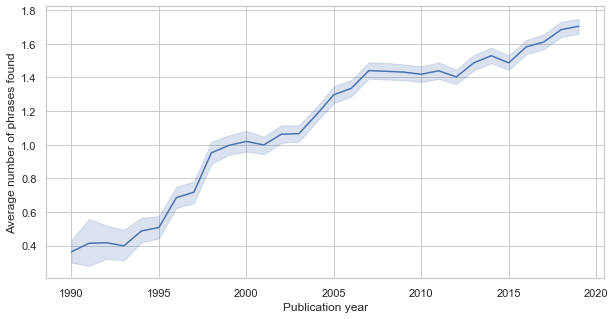

In [15]:
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")
plot_df = combined_df.copy()
plot_df.loc[plot_df.loc[:, "Publication year"] < 1990, "Publication year"] = 1990
plot_df.loc[plot_df.loc[:, "Publication year"] > 2019, "Publication year"] = 2019

sns.lineplot(x="Publication year", y="Total number of phrases found", data=plot_df)
plt.ylabel("Average number of phrases found")
plt.show();